In [2]:
import os
import pickle 
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt

from config import *

from functools import reduce 

import logging
logging.basicConfig(level=logging.DEBUG, format="%(asctime)s [%(levelname)s] %(message)s", 
                    datefmt="%d-%b-%y %H:%M:%S")

In [15]:
DATASET_NAME_MAP = {"breast-cancer-wisconsin": "Breast Cancer", 
                            "gaussian_df": "Gaussian", 
                            "rectangle_df": "Rectangle", 
                            "uniform_df": "Uniform", 
                            "Brain Tumor": "Brain Tumor"}


In [48]:
class ReportGenerator:
    def __init__(self, dataset: str, num_exps: int = 6,
                 rules_folder: str = RULE_FOLDER, 
                 results_file: str = "experiments.csv", 
                 res_df_cols_ignore: list = ["breaks",	"mult_rules", 	"confusion_matrix",	"label_for_dist"], 
                 exps_to_ignore: list = None):
        # logging.info(f"Working with dataset `{dataset}`, num_exps `{num_exps}`, rules_folder `{rules_folder}`, results_file `{results_file}`")
                
        self.exps_to_ignore = exps_to_ignore
                
        assert os.path.exists(rules_folder), f"Rules folder `{rules_folder}` does not exist"
        assert os.path.exists(results_file), f"Results csv file `{results_file}` does not exist"
        
        self.dataset = dataset
        self.dataset_lst = os.listdir(rules_folder)
        assert self.dataset in self.dataset_lst, \
            f"No rules folder found for dataset `{dataset}` in folder `{rules_folder}`, found {self.dataset_lst}"
        
        self.dataset_name = DATASET_NAME_MAP[self.dataset]
        
        # ----------------------- Load rules ----------------------- #
        self.rules_results_lst = os.listdir(os.path.join(rules_folder, self.dataset))

        assert len(self.rules_results_lst) == num_exps, f"Expected {num_exps} experiments, found list -> {self.rules_results_lst}"

        if self.exps_to_ignore:
            self.rules_results_lst = self.ignore_experiments(self.rules_results_lst)
                    
        self.exp_names = [self.get_experiment_name(i) for i in self.rules_results_lst]

        self.exp_full_names = [i.split(".")[0] for i in self.rules_results_lst]
        
        self.rules_dict = {}
        for exp_rule in self.rules_results_lst:
            exp_name = self.get_experiment_name(exp_rule)
            
            rule_file_name = os.path.join(rules_folder, self.dataset, exp_rule)
            rule_pickle = pickle.load(open(rule_file_name, "rb"))
            rule_dict = self.extract_rule_info(rule_pickle)
            self.rules_dict[exp_name] = pd.DataFrame(rule_dict)

        self.rules_df = self.convert_rules_dict_to_df()


        logging.info(f"Rules files for path `{rules_folder}/{dataset}` loaded")
        # ----------------------- Load df results ----------------------- #
        self.res_df_cols_ignore = res_df_cols_ignore
        self.res_df = pd.read_csv(results_file, usecols=lambda x: x not in self.res_df_cols_ignore)
       
        self.res_df = self.res_df[self.res_df["name"].isin(self.exp_full_names)].tail(len(self.rules_results_lst))
        
        # assert len(self.res_df) == num_exps, f"Expected {num_exps } experiments, found {len(self.res_df)}"
        
        self.res_df["exp_name"] = self.res_df.apply(self.get_experiment_name_for_df, axis=1)
        assert set(self.res_df["exp_name"]) == set(self.exp_names), \
            f"Most likely missing some experiments. Found {set(self.res_df['exp_name'])}, expected {set(self.exp_names)}"
            
        self.res_df["initial_loss"] = self.res_df["all_losses"].apply(lambda x: eval(x)[0])
        logging.info(f"Experiments {self.exp_names}")
        logging.info(f"Results for dataset `{dataset}` loaded") 
    
    def ignore_experiments(self, lst):
        exps = []
        for i in lst:
            if self.get_experiment_name(i) not in self.exps_to_ignore:
                exps.append(i)
        return exps
    
    def get_bar_plots_res(self, ys=["training_time", "accuracy", "f1", "min_loss", "initial_loss"], 
                             show=False):
        # get_bar = lambda y
        fig = px.bar(self.res_df, x="exp_name", y=ys, 
                     title=f"Metrics for dataset `{self.dataset}`", 
                     barmode='group')
                     # stack next to each other
                        
        return fig
    
    def get_uncertainty_comparison(self):
        uncertainty_cols = [i for i in self.rules_df.columns if "uncertainty" in i]
        stats = self.rules_df[uncertainty_cols].describe().loc[["mean", "50%"]]
        stats.rename(index={"50%": "median"}, inplace=True)

        # ChatGPT code
        flat_df = stats.stack().to_frame().T  # The to_frame().T converts the series to a single-row DataFrame

        new_columns = [f'{stat}_{col[1].split("uncertainty_")[1]}' for col in flat_df.columns for stat in ['mean', 'median'] if stat in col[0]]
        flat_df.columns = new_columns

        flat_df.index = [self.dataset_name]
        
        flat_df["improvement"] = flat_df["median_random"] / flat_df["median_means_no_clustering"]

        self.uncs_df = flat_df
        return flat_df

    def convert_rules_dict_to_df(self):
        # https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns
        dfs_with_suffixes = [(self.rules_dict[exp_name], f"_{exp_name}") for exp_name in self.rules_dict]
        first_df = dfs_with_suffixes[0][0]
        first_df_name = dfs_with_suffixes[0][1]
        the_rest_dfs = dfs_with_suffixes[1:]

        merge_one = lambda x, y, sfx: pd.merge(x, y, on=['rule'], suffixes=("", sfx))

        merged = reduce(lambda left, right: merge_one(left,*right), the_rest_dfs, first_df)
        
        merged.rename(columns={"mass_first": f"mass_first{first_df_name}", 
                                "mass_second": f"mass_second{first_df_name}",
                                "uncertainty": f"uncertainty{first_df_name}"}, inplace=True)
        return merged
    
    @staticmethod
    def extract_rule_info(rules_info):
        rules = rules_info["preds"]
        mafs = rules_info["masses"]
        
        rule_names = [str(i) for i in rules]
        mass_first = [float(i[0]) for i in mafs]
        mass_second = [float(i[1]) for i in mafs]
        uncertainty = [float(i[2]) for i in mafs]
        
        res = {"rule": rule_names, "mass_first": mass_first, "mass_second": mass_second, "uncertainty": uncertainty}
        return res
    
    @staticmethod
    def get_experiment_name(file_name):
        parts = file_name.split(',', 1) 
        file_name = parts[1].strip() if len(parts) > 1 else ''
        # without code above will fail when method and dataset are both `uniform `        
        if "uniform" in file_name:
            return "uniform"
        elif "random" in file_name:
            return "random"
        elif "means_no_clustering" in file_name:
            return "means_no_clustering"
        elif "density_no_clustering" in file_name:
            return "density_no_clustering"
        elif "clustering" in file_name:
            if "kmeans" in file_name:
                return "kmeans"
            elif "dbscan" in file_name:
                return "dbscan"
            
    @staticmethod
    def get_experiment_name_for_df(df):
        if df["MAF method"] != "clustering":
            return df["MAF method"]
        return df["clustering_alg"]

In [49]:
R = ReportGenerator("uniform_df", num_exps=6, exps_to_ignore=["dbscan", "kmeans", "uniform", "density_no_clustering"])

04-May-24 19:55:41 [INFO] Rules files for path `rules/uniform_df` loaded


04-May-24 19:55:41 [INFO] Experiments ['means_no_clustering', 'random']
04-May-24 19:55:41 [INFO] Results for dataset `uniform_df` loaded


In [50]:
R.res_df.head(1)

,datetime,name,MAF method,dataset,accuracy,f1,training_time,epochs,min_loss,all_losses,clustering_alg,exp_name,initial_loss
163,04-05-2024 04:44:50,"dataset=uniform_df, label_for_dist=labels, clu...",clustering,uniform_df,0.973333,0.969697,56.481622,191,0.036866,"[0.19784381985664368, 0.1942012906074524, 0.19...",means_no_clustering,means_no_clustering,0.197844


In [51]:
R.res_df

,datetime,name,MAF method,dataset,accuracy,f1,training_time,epochs,min_loss,all_losses,clustering_alg,exp_name,initial_loss
163,04-05-2024 04:44:50,"dataset=uniform_df, label_for_dist=labels, clu...",clustering,uniform_df,0.973333,0.969697,56.481622,191,0.036866,"[0.19784381985664368, 0.1942012906074524, 0.19...",means_no_clustering,means_no_clustering,0.197844
165,04-05-2024 04:46:54,"dataset=uniform_df, label_for_dist=labels, clu...",random,uniform_df,0.973333,0.969697,82.151682,273,0.037534,"[0.25353994965553284, 0.2508929371833801, 0.24...",NaN,random,0.253540


In [52]:
# MAF method & dataset & accuracy & f1 & training\_time & epochs & min\_loss & initial\_loss\\
R.res_df[["MAF method", "dataset", "accuracy", "f1", "training_time", "epochs", "min_loss", "initial_loss"]]

,MAF method,dataset,accuracy,f1,training_time,epochs,min_loss,initial_loss
163,clustering,uniform_df,0.973333,0.969697,56.481622,191,0.036866,0.197844
165,random,uniform_df,0.973333,0.969697,82.151682,273,0.037534,0.253540


In [53]:
def get_res_df_all_datasets():
    dataset_lst = os.listdir(RULE_FOLDER)
    dataset_lst = [i for i in dataset_lst if i not in  ["gaussian_df_before_fix", "wine"]]
    
    res_dfs = []
    for dataset in dataset_lst:
        R = ReportGenerator(dataset, num_exps=6, exps_to_ignore=["dbscan", "kmeans", "density_no_clustering"])
        res_dfs.append(R.res_df)
    return pd.concat(res_dfs)

In [54]:
res = get_res_df_all_datasets()
res = res[["MAF method", "dataset", "accuracy", "f1", "training_time", "epochs", "min_loss", "initial_loss"]].round(3)



04-May-24 19:55:59 [INFO] Rules files for path `rules/Brain Tumor` loaded
04-May-24 19:55:59 [INFO] Experiments ['means_no_clustering', 'random', 'uniform']
04-May-24 19:55:59 [INFO] Results for dataset `Brain Tumor` loaded


04-May-24 19:55:59 [INFO] Rules files for path `rules/breast-cancer-wisconsin` loaded
04-May-24 19:55:59 [INFO] Experiments ['means_no_clustering', 'random', 'uniform']
04-May-24 19:55:59 [INFO] Results for dataset `breast-cancer-wisconsin` loaded
04-May-24 19:55:59 [INFO] Rules files for path `rules/gaussian_df` loaded
04-May-24 19:55:59 [INFO] Experiments ['means_no_clustering', 'random', 'uniform']
04-May-24 19:55:59 [INFO] Results for dataset `gaussian_df` loaded
04-May-24 19:55:59 [INFO] Rules files for path `rules/rectangle_df` loaded
04-May-24 19:55:59 [INFO] Experiments ['means_no_clustering', 'random', 'uniform']
04-May-24 19:55:59 [INFO] Results for dataset `rectangle_df` loaded
04-May-24 19:55:59 [INFO] Rules files for path `rules/uniform_df` loaded
04-May-24 19:55:59 [INFO] Experiments ['means_no_clustering', 'random', 'uniform']
04-May-24 19:55:59 [INFO] Results for dataset `uniform_df` loaded


In [ ]:
lst = [186.503	/ 72, ]

In [55]:
res  

,MAF method,dataset,accuracy,f1,training_time,epochs,min_loss,initial_loss
139,clustering,Brain Tumor,0.981,0.979,72.832,75,0.023,0.410
141,random,Brain Tumor,0.983,0.981,288.722,133,0.026,0.241
142,uniform,Brain Tumor,0.984,0.982,186.503,86,0.023,0.250
145,clustering,breast-cancer-wisconsin,0.966,0.952,32.671,82,0.022,0.614
147,random,breast-cancer-wisconsin,0.971,0.959,31.940,111,0.030,0.336
148,uniform,breast-cancer-wisconsin,0.976,0.966,10.428,71,0.026,0.250
151,clustering,gaussian_df,0.987,0.988,41.419,135,0.020,0.148
153,random,gaussian_df,0.967,0.969,91.876,273,0.023,0.282
154,uniform,gaussian_df,0.987,0.988,60.823,190,0.024,0.250
157,clustering,rectangle_df,1.000,1.000,122.795,168,0.006,0.165


In [10]:
res.to_latex("paper/res_df.tex", index=False)

In [11]:
res

,MAF method,dataset,accuracy,f1,training_time,epochs,min_loss,initial_loss
139,clustering,Brain Tumor,0.981,0.979,72.832,75,0.023,0.410
141,random,Brain Tumor,0.983,0.981,288.722,133,0.026,0.241
145,clustering,breast-cancer-wisconsin,0.966,0.952,32.671,82,0.022,0.614
147,random,breast-cancer-wisconsin,0.971,0.959,31.940,111,0.030,0.336
151,clustering,gaussian_df,0.987,0.988,41.419,135,0.020,0.148
153,random,gaussian_df,0.967,0.969,91.876,273,0.023,0.282
157,clustering,rectangle_df,1.000,1.000,122.795,168,0.006,0.165
159,random,rectangle_df,1.000,1.000,212.407,287,0.007,0.253
163,clustering,uniform_df,0.973,0.970,56.482,191,0.037,0.198
165,random,uniform_df,0.973,0.970,82.152,273,0.038,0.254


In [157]:
R.get_uncertainty_comparison()

,mean_density_no_clustering,mean_means_no_clustering,mean_random,median_density_no_clustering,median_means_no_clustering,median_random
Uniform,0.220156,0.188726,0.266291,0.266034,0.10557,0.128633


In [29]:
def get_uncertainties_all_datasets():
    dataset_lst = os.listdir(RULE_FOLDER)
    dataset_lst = [i for i in dataset_lst if i not in  ["gaussian_df_before_fix", "wine"]]
    
    all_uncs = pd.DataFrame()
    for dataset in dataset_lst:
        R = ReportGenerator(dataset, num_exps=6)
        res = R.get_uncertainty_comparison()
        all_uncs = pd.concat([all_uncs, res])
        
    average_imp = all_uncs["improvement"].mean()
    print(average_imp)
    return all_uncs

In [44]:
df = get_uncertainties_all_datasets()

04-May-24 19:47:08 [INFO] Rules files for path `rules/Brain Tumor` loaded
04-May-24 19:47:08 [INFO] Experiments ['dbscan', 'density_no_clustering', 'kmeans', 'means_no_clustering', 'random', 'uniform']
04-May-24 19:47:08 [INFO] Results for dataset `Brain Tumor` loaded
04-May-24 19:47:08 [INFO] Rules files for path `rules/breast-cancer-wisconsin` loaded
04-May-24 19:47:08 [INFO] Experiments ['dbscan', 'density_no_clustering', 'kmeans', 'means_no_clustering', 'random', 'uniform']
04-May-24 19:47:08 [INFO] Results for dataset `breast-cancer-wisconsin` loaded
04-May-24 19:47:08 [INFO] Rules files for path `rules/gaussian_df` loaded
04-May-24 19:47:08 [INFO] Experiments ['dbscan', 'density_no_clustering', 'kmeans', 'means_no_clustering', 'random', 'uniform']
04-May-24 19:47:08 [INFO] Results for dataset `gaussian_df` loaded
04-May-24 19:47:08 [INFO] Rules files for path `rules/rectangle_df` loaded
04-May-24 19:47:08 [INFO] Experiments ['dbscan', 'density_no_clustering', 'kmeans', 'means_no_

1.380957297187268


In [45]:
df

,mean_dbscan,mean_density_no_clustering,mean_kmeans,mean_means_no_clustering,mean_random,mean_uniform,median_dbscan,median_density_no_clustering,median_kmeans,median_means_no_clustering,median_random,median_uniform,improvement
Brain Tumor,0.440822,0.435831,0.304737,0.423327,0.708778,0.368254,0.417441,0.411201,0.310397,0.418098,0.736886,0.360935,1.762472
Breast Cancer,0.488162,0.462914,0.361244,0.459894,0.716614,0.356738,0.570609,0.516539,0.327393,0.465281,0.714142,0.347247,1.534860
Gaussian,0.264013,0.263728,0.252323,0.274464,0.331658,0.315156,0.290169,0.290060,0.257930,0.271403,0.311276,0.312642,1.146915
Rectangle,0.249777,0.249777,0.248819,0.269199,0.301595,0.240958,0.255210,0.255210,0.216087,0.239695,0.340009,0.238029,1.418508
Uniform,0.220156,0.220156,0.195312,0.188726,0.277344,0.188463,0.266034,0.266034,0.116399,0.105570,0.110007,0.133961,1.042033


In [33]:
# df = df[["mean_random", "mean_means_no_clustering", "median_random", "median_means_no_clustering", "improvement"]]

In [37]:
# df.rename(columns={"mean_random": "Mean Random", "mean_means_no_clustering": "Mean Confidence", 
#                      "median_random": "Median Random", "median_means_no_clustering": "Median Confidence",
#                      "improvement": "Improvement, x"}, inplace=True)

C:\Users\hayk_\AppData\Local\Temp\ipykernel_15416\1485344044.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"mean_random": "Mean Random", "mean_means_no_clustering": "Mean Confidence",


In [39]:
# df.to_latex("paper/uncertainties.tex", index=True, float_format="%.2f")  

In [42]:
# df["Improvement"].mean()

1.380957297187268

04-May-24 19:47:42 [DEBUG] Loaded backend module://matplotlib_inline.backend_inline version unknown.
04-May-24 19:47:42 [DEBUG] Loaded backend module://matplotlib_inline.backend_inline version unknown.
04-May-24 19:47:42 [DEBUG] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
04-May-24 19:47:42 [DEBUG] findfont: score(FontEntry(fname='c:\\Users\\hayk_\\.conda\\envs\\thesis\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
04-May-24 19:47:42 [DEBUG] findfont: score(FontEntry(fname='c:\\Users\\hayk_\\.conda\\envs\\thesis\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
04-May-24 19:47:42 [DEBUG] findfont: score(FontEntry(fname='c:\\Users\\hayk_\\.conda\\envs\\thesis\\lib\\site-packages\\

<Axes: >

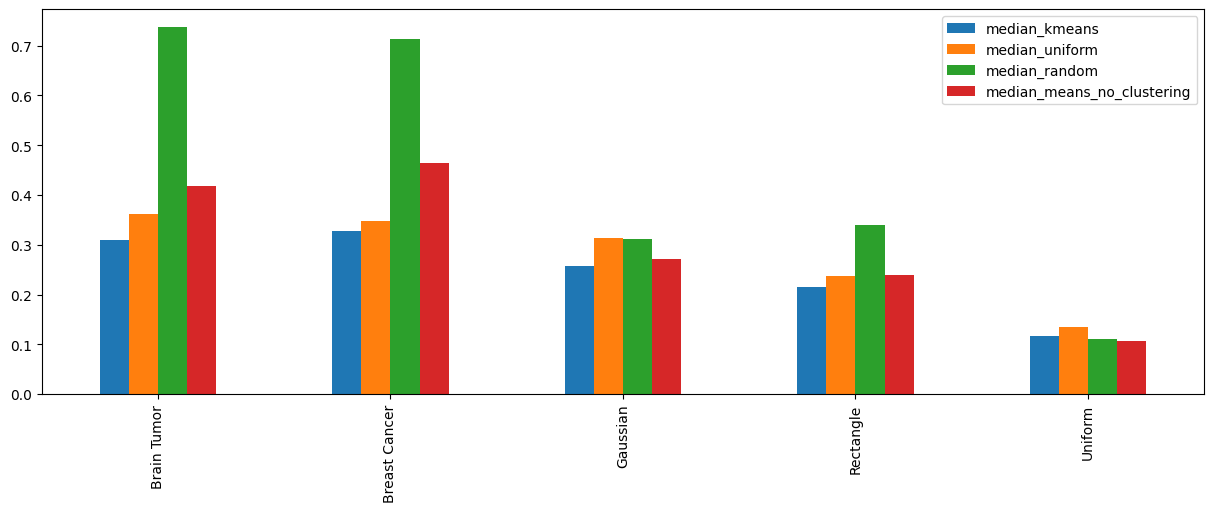

In [46]:
cols_int = ["mean_kmeans", "mean_uniform", "mean_random", "mean_means_no_clustering"]
cols_int_median = ["median_kmeans", "median_uniform", "median_random", "median_means_no_clustering"]
df[cols_int_median].plot(kind="bar", figsize=(15, 5))

In [47]:
res  

,MAF method,dataset,accuracy,f1,training_time,epochs,min_loss,initial_loss
139,clustering,Brain Tumor,0.981,0.979,72.832,75,0.023,0.410
141,random,Brain Tumor,0.983,0.981,288.722,133,0.026,0.241
145,clustering,breast-cancer-wisconsin,0.966,0.952,32.671,82,0.022,0.614
147,random,breast-cancer-wisconsin,0.971,0.959,31.940,111,0.030,0.336
151,clustering,gaussian_df,0.987,0.988,41.419,135,0.020,0.148
153,random,gaussian_df,0.967,0.969,91.876,273,0.023,0.282
157,clustering,rectangle_df,1.000,1.000,122.795,168,0.006,0.165
159,random,rectangle_df,1.000,1.000,212.407,287,0.007,0.253
163,clustering,uniform_df,0.973,0.970,56.482,191,0.037,0.198
165,random,uniform_df,0.973,0.970,82.152,273,0.038,0.254


In [26]:
def ratio_calc(group):
    ratios = {}
    # Get data for clustering and random methods
    clustering = group[group['MAF method'] == 'clustering']
    random = group[group['MAF method'] == 'random']
    
    # Calculate the ratios
    # make calss below numeric type
    clustering['accuracy'] = pd.to_numeric(clustering['accuracy'])
    random['accuracy'] = pd.to_numeric(random['accuracy'])
    clustering['f1'] = pd.to_numeric(clustering['f1'])
    random['f1'] = pd.to_numeric(random['f1'])
    clustering['training_time'] = pd.to_numeric(clustering['training_time'])
    random['training_time'] = pd.to_numeric(random['training_time'])
    
    ratios['accuracy_ratio'] = clustering['accuracy'].values[0] / random['accuracy'].values[0]
    ratios['f1_ratio'] = clustering['f1'].values[0] / random['f1'].values[0]
    ratios['training_time_speedup'] =  random['training_time'].values[0] / clustering['training_time'].values[0]
    
    return pd.Series(ratios)

# Apply the function to each dataset group and reset index for better format
ratios_df = res.groupby('dataset').apply(ratio_calc).reset_index()

# Display the new DataFrame
ratios_df["dataset"] = ratios_df["dataset"].replace(DATASET_NAME_MAP)
ratios_df.rename({"accuracy_ratio": "Accuracy Ratio", "f1_ratio": "F1 Ratio", "training_time_speedup": "Training Time Speedup, x"}, axis=1, inplace=True)
ratios_df.round(2).to_latex("paper/acc_time_ratios_df.tex", index=False, float_format=lambda x: '%.2f' % x)


C:\Users\hayk_\AppData\Local\Temp\ipykernel_15416\881398984.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios_df = res.groupby('dataset').apply(ratio_calc).reset_index()


In [28]:
ratios_df["Training Time Speedup, x"].mean()

2.0688607354332005

In [19]:
DATASET_NAME_MAP

{'breast-cancer-wisconsin': 'Breast Cancer',
 'gaussian_df': 'Gaussian',
 'rectangle_df': 'Rectangle',
 'uniform_df': 'Uniform',
 'Brain Tumor': 'Brain Tumor'}

In [59]:
# means = R.rules_df[uncertainty_cols].mean()
# medians = R.rules_df[uncertainty_cols].median()

# mean and median of uncertainty for each experiment


                mean                                                       \
  uncertainty_dbscan uncertainty_density_no_clustering uncertainty_kmeans   
0           0.264013                          0.263728           0.252323   

                                                                          \
  uncertainty_means_no_clustering uncertainty_random uncertainty_uniform   
0                        0.274464           0.336454            0.315156   

              median                                                       \
  uncertainty_dbscan uncertainty_density_no_clustering uncertainty_kmeans   
0           0.290169                           0.29006            0.25793   

                                                                          
  uncertainty_means_no_clustering uncertainty_random uncertainty_uniform  
0                        0.271403           0.314481            0.312642  


,mean_dbscan,mean_clustering,mean_kmeans,mean_clustering,mean_random,mean_uniform,median_dbscan,median_clustering,median_kmeans,median_clustering,median_random,median_uniform
ABC,0.264013,0.263728,0.252323,0.274464,0.336454,0.315156,0.290169,0.29006,0.25793,0.271403,0.314481,0.312642


In [60]:
r.stack()

mean    uncertainty_dbscan                   0.264013
        uncertainty_density_no_clustering    0.263728
        uncertainty_kmeans                   0.252323
        uncertainty_means_no_clustering      0.274464
        uncertainty_random                   0.336454
        uncertainty_uniform                  0.315156
median  uncertainty_dbscan                   0.290169
        uncertainty_density_no_clustering    0.290060
        uncertainty_kmeans                   0.257930
        uncertainty_means_no_clustering      0.271403
        uncertainty_random                   0.314481
        uncertainty_uniform                  0.312642
dtype: float64

In [55]:
# # get mean and median of uncertainties
# means = R.rules_df[uncertainty_cols].mean()
# medians = R.rules_df[uncertainty_cols].median()

# combined_df = pd.concat([means, medians], axis=1)#.rename(columns={0: "DATASET_NAME"})

# combined_df = combined_df.T  # Transpose to switch rows and columns

# # # Rename columns to distinguish means from medians
# combined_df.columns = [f'{col}_mean' for col in means.index] + [f'{col}_median' for col in medians.index]

# # # Set the index to a single row named 'ABC'
# # combined_df.index = ['ABC']

# combined_df

In [36]:
R.get_bar_plots_res(show=False)

In [23]:
from pandas import option_context

with option_context('display.max_colwidth', 400):
    print(R.df_res[["name", "clustering_alg", "exp_name"]])




                                                                                                                               name  \
96                  dataset=Brain Tumor, label_for_dist=labels, clust=kmeans, breaks=3, add_mult_rules=False, maf_method=clustering   
97                  dataset=Brain Tumor, label_for_dist=labels, clust=dbscan, breaks=3, add_mult_rules=False, maf_method=clustering   
98     dataset=Brain Tumor, label_for_dist=labels, clust=means_no_clustering, breaks=3, add_mult_rules=False, maf_method=clustering   
99   dataset=Brain Tumor, label_for_dist=labels, clust=density_no_clustering, breaks=3, add_mult_rules=False, maf_method=clustering   
100                       dataset=Brain Tumor, label_for_dist=labels, clust=None, breaks=3, add_mult_rules=False, maf_method=random   
101                      dataset=Brain Tumor, label_for_dist=labels, clust=None, breaks=3, add_mult_rules=False, maf_method=uniform   

            clustering_alg               exp_name  
96

In [82]:
merged.head(1)

,rule,mass_first,mass_second,uncertainty,mass_first_kmeans,mass_second_kmeans,uncertainty_kmeans,mass_first_random,mass_second_random,uncertainty_random,mass_first_uniform,mass_second_uniform,uncertainty_uniform
0,x < 0.321,0.0,0.806145,0.193855,0.0,0.834516,0.165484,0.0,0.717049,0.282951,0.0,0.758178,0.241822


In [83]:
merged_manual.head(1)

,rule,mass_first,mass_second,uncertainty,mass_first_kmeans,mass_second_kmeans,uncertainty_kmeans,mass_first_random,mass_second_random,uncertainty_random,mass_first_uniform,mass_second_uniform,uncertainty_uniform
0,x < 0.321,0.0,0.806145,0.193855,0.0,0.834516,0.165484,0.0,0.717049,0.282951,0.0,0.758178,0.241822
